In [1]:
source("../usr/lib/kalmanfilterfunctions/kalmanfilterfunctions.R")
example_loads <- read.csv('../input/example-training-loads/example_loads.csv')

set.seed(523445)

In [2]:
kalman_model <- create_kalman_model(p_0 = 400, k_g = .1, k_h = .3, tau_g = 50,
                                    tau_h = 15, xi = 15,
                                    sigma_g = 20, sigma_h = 10, rho_gh = .2,
                                    initial_g = 1500, initial_h = 500,
                                    initial_sd_g = 500, initial_sd_h = 250,
                                    initial_rho_gh = 0)
print(kalman_model)


------- Your Kalman Filter Model -----
------- State Model ------------------
        A                              B                        
x_n = [ 0.9802 0.0000 ] *  x_(n-1) + [ 0.9802 ] * w_(n-1) + v_n 
        0.0000 0.9355                  0.9355                   
where
              Q         
v_n ~ N( 0 ,  400  40 ) 
         0     40 100   
and
                            M_0             
x_0 =[ 1500 ], Var(x_0) = [ 250000      0 ] 
        500                      0  62500   

------- Meansurement Model ------------
              C                         
y_n = 400 + [  0.1 -0.3 ] * x_n + eta_n 

where
                xi      
eta_n ~ N( 0 ,  15 ^ 2) 


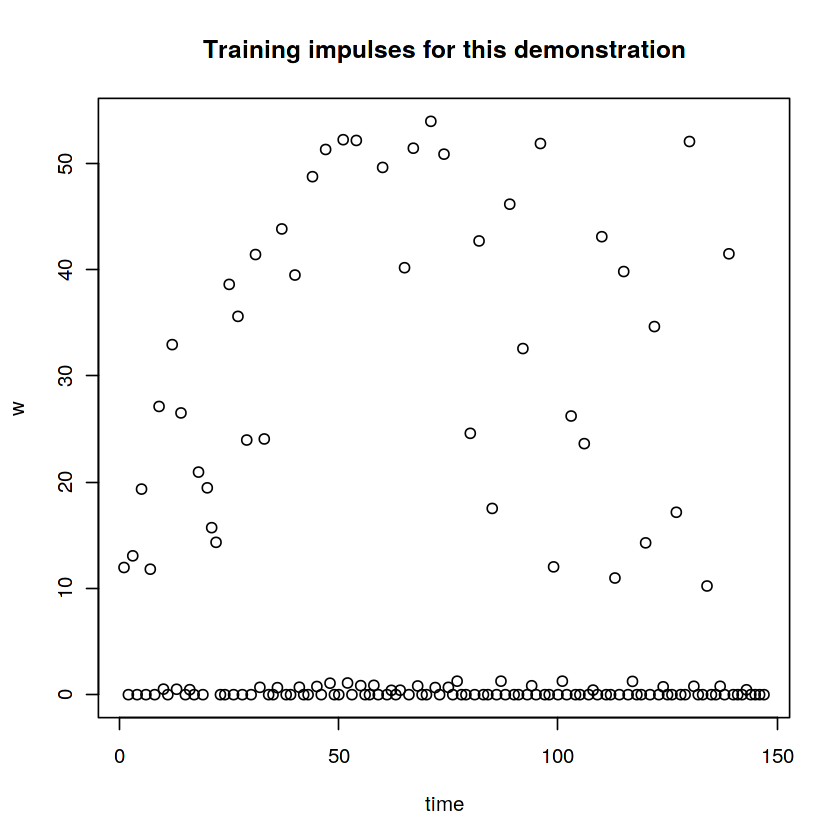

In [3]:
# The Training Plan -----------------------------------------------------------

# "upper body", "lower body", "synthetic"
training_type <- "upper body" 

if (training_type == "synthetic") {
  w <- rep(c(seq(10, 50), rep(20, 14)), 5)
  w <- c(w, rep(0, 100), w)  #  Adding long rest!
} else if (training_type == "upper body") {
  w <- as.numeric(example_loads$tl_upper_fitness)
} else if (training_type == "lower body") {
  w <- as.numeric(example_loads$tl_lower_fitness)
}

plot(w, main = "Training impulses for this demonstration", xlab = "time")

In [4]:
set.seed(134323)
df <- simulate(kalman_model, w)
head(df)

,t,w,y,true_fitness,true_fatigue
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,11.97,390.3961,1500.000,500.0000
2,2,0.00,424.0550,1509.355,463.2779
3,3,13.07,410.2352,1476.836,434.9744
4,4,0.00,407.9461,1472.404,419.5600
5,5,19.35,409.0775,1444.548,408.4042
6,6,0.00,451.2260,1447.771,399.0236


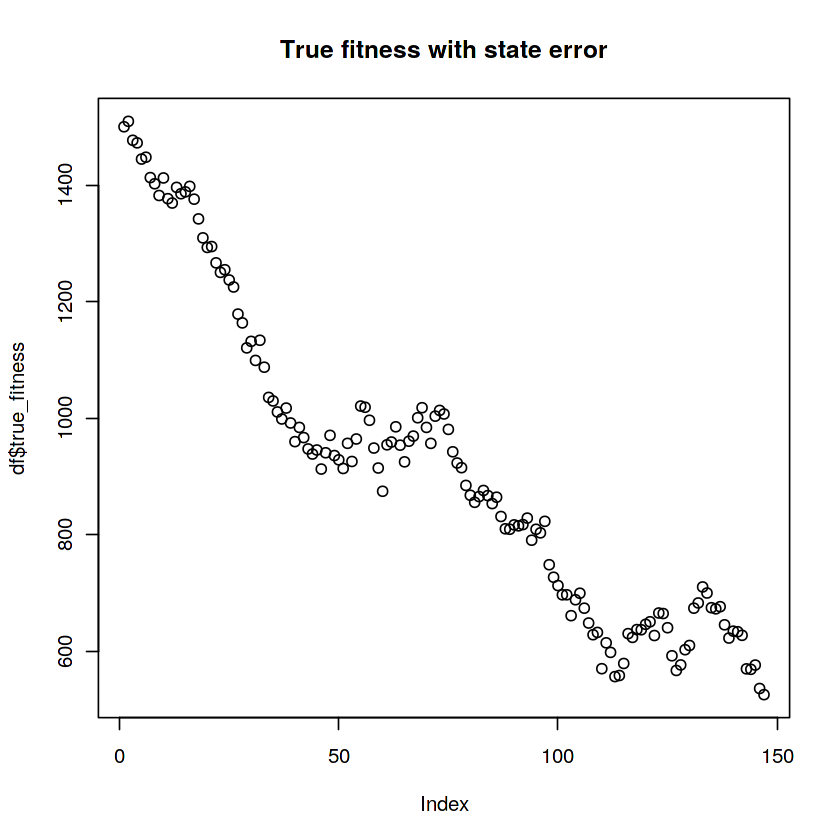

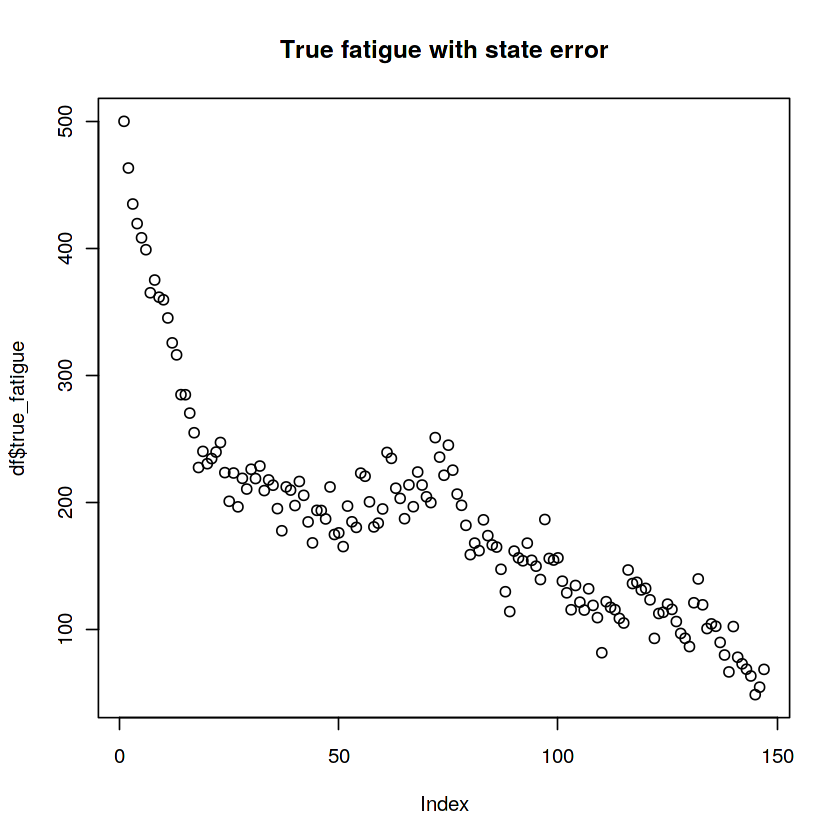

In [5]:
# Note that state error can lead to fitness and fatigue dropping below 0
plot(df$true_fitness, main = "True fitness with state error")
plot(df$true_fatigue, main = "True fatigue with state error")

In [6]:
# get aquinted with the data structure produced by filter()
filtered <- filter(kalman_model, df)
names(filtered)

print("filtered$df will have variable 'y_hat'")
head(filtered$df)
print("filtered$X is a matrix with fitness (column 1) and fatigue (column 2)")
head(filtered$X)

[1] "df"      "X"       "M"       "loglike"

[1] "filtered$df will have variable 'y_hat'"


,t,w,y,true_fitness,true_fatigue,y_hat
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>"
1,1,11.97,390.3961,1500.000,500.0000,390.6549
2,2,0.00,424.0550,1509.355,463.2779,409.4062
3,3,13.07,410.2352,1476.836,434.9744,413.8534
4,4,0.00,407.9461,1472.404,419.5600,414.6250
5,5,19.35,409.0775,1444.548,408.4042,417.2370
6,6,0.00,451.2260,1447.771,399.0236,426.6763


[1] "filtered$X is a matrix with fitness (column 1) and fatigue (column 2)"


1471.246,521.5656
1545.841,483.9264
1492.477,451.3144
1429.651,427.8003
1341.168,389.5995
1519.500,417.5789


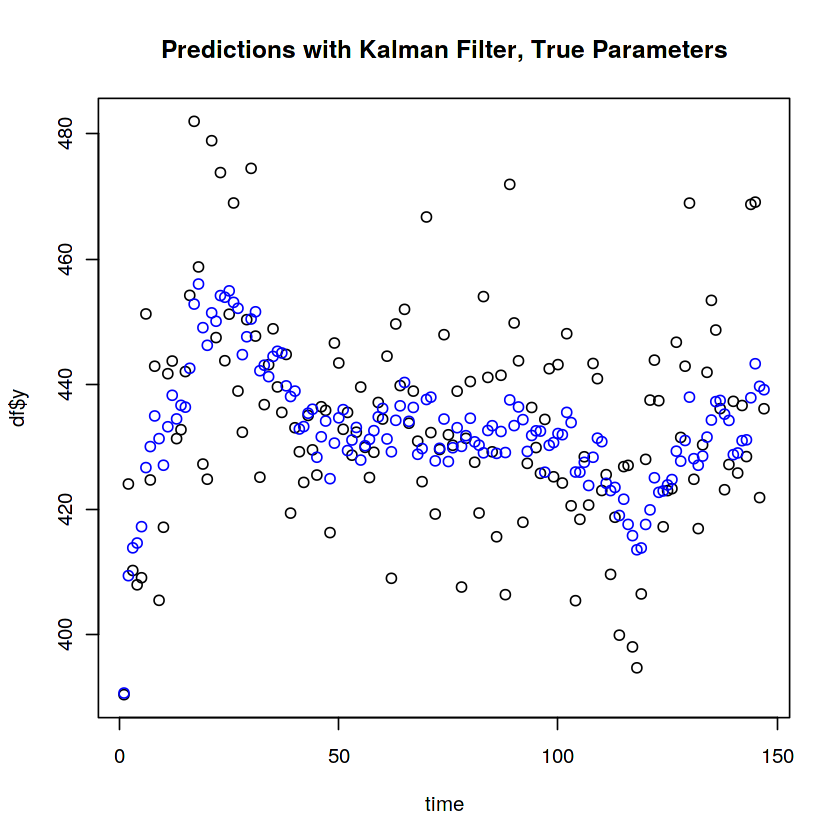

In [7]:
# Predictions with True Parameters
plot(df$y, xlab = "time",
     main = "Predictions with Kalman Filter, True Parameters")
points(filtered$df$y_hat, col = 'blue')

In [8]:
kf_from_data <- initialize_kalman_from_data(df)
print(kf_from_data)


------- Your Kalman Filter Model -----
------- State Model ------------------
        A                              B                        
x_n = [ 0.9512 0.0000 ] *  x_(n-1) + [ 0.9512 ] * w_(n-1) + v_n 
        0.0000 0.9355                  0.9355                   
where
              Q                   
v_n ~ N( 0 ,  258.3915   0.0000 ) 
         0      0.0000 249.9204   
and
                                M_0                 
x_0 =[ 143.1828 ], Var(x_0) = [ 5125.328    0.000 ] 
       123.0236                    0.000 3783.703   

------- Meansurement Model ------------
                   C                               
y_n = 432.0993 + [  0.3000 -0.4049 ] * x_n + eta_n 

where
                xi           
eta_n ~ N( 0 ,  16.3103 ^ 2) 


In [ ]:
kf_ml <- maximize_likelihood(kf_from_data, df)
print(kf_ml)

In [ ]:
filtered <- filter(kf_ml, df)

plot(filtered$X[, 1], main = "Estimated fitness")
plot(filtered$X[, 2], main = "Estimated fatigue")

In [ ]:
plot(y ~ t, data = df, main = "Observed and Kalman Filter predictions")
points(filtered$df$y_hat, col = 'blue')